In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_log_error

In [16]:
train = pd.read_csv("../data/train.csv", index_col="date", parse_dates=True)
train["family_store"] = train["family"] + "_" + train["store_nbr"].astype(str)

test = pd.read_csv("../data/test.csv", index_col="date", parse_dates=True)
test["family_store"] = test["family"] + "_" + test["store_nbr"].astype(str)

train_set = train.rename(columns={"date":"ds", "sales":"y"}).drop(columns=["id", "family", "store_nbr"])
test_set = test.rename(columns={"date":"ds", "sales":"y"}).drop(columns=["id", "family", "store_nbr"])

In [13]:
len(train["family"].unique())

33

<Axes: xlabel='date'>

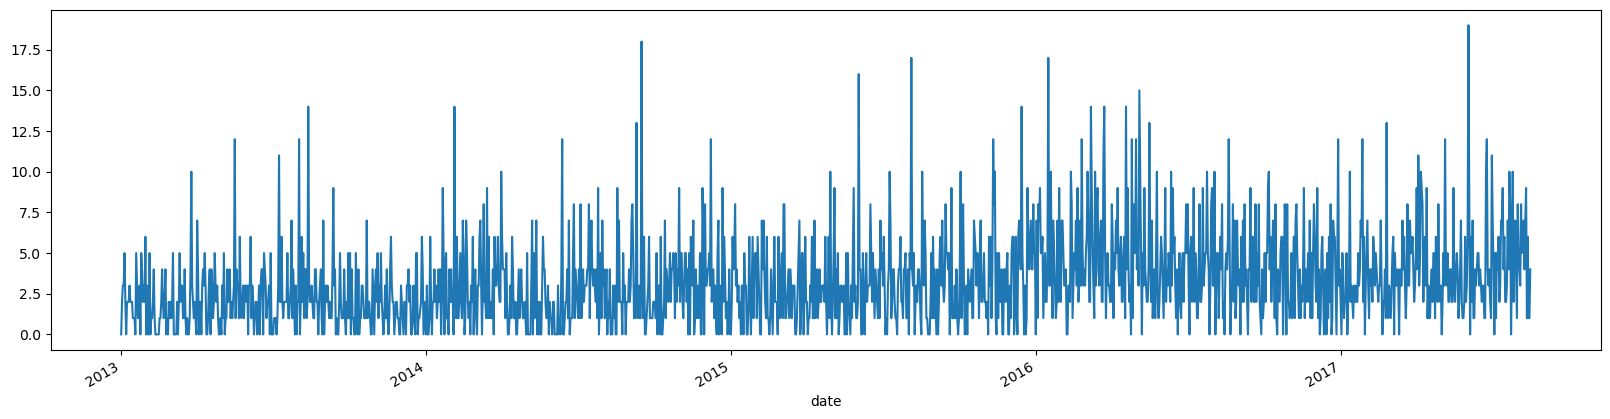

In [22]:
plt.figure(figsize=(20,5))
train_set[train_set["family_store"] == train_set["family_store"].unique()[0]]["y"].plot()

In [24]:
period = (pd.Timestamp("2013-01-01"), pd.Timestamp("2016-08-15"), pd.Timestamp("2016-08-31"))
train["ds"] = pd.to_datetime(train["ds"])
train_set = train[(train["ds"] >= period[0]) & (train["ds"] <= period[1])]
valid_set = train[(train["ds"] > period[1]) & (train["ds"] <= period[2])]

KeyError: 'ds'

In [25]:
for fs in tqdm([train_set["family_store"].unique()[0]]):
    single = train_set[train_set["family_store"] == fs].drop(columns="family_store")
    single = single.asfreq("d")
    single_ts = PandasDataset(single, target="y")

    estimator = DeepAREstimator(
        prediction_length=1,
        freq="D", 
        batch_size=32,
        num_batches_per_epoch=50,
        lr=0.01,
        hidden_size=30,
        num_layers=2,
    )
    predictor = estimator.train(single_ts)
    
    # future = pd.DataFrame()
    # future['ds'] = pd.date_range(start='2016-08-16',periods=16,freq='D')
    # forecast = model.predict(len(future['ds']))
    # y_pred = forecast.values()

  0%|          | 0/1 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params | In sizes                                                        | Out sizes  
----------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 15.8 K | [[1, 1], [1, 1], [1, 1093, 4], [1, 1093], [1, 1093], [1, 1, 4]] | [1, 100, 1]
----------------------------------------------------------------------------------------------------------------------
15.8 K    Trainable params
0         Non-trainable params
15.8 K    Total params
0.063     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 7.51483 (best 7.51483), saving model to 'c:\\Users\\ghckd\\Documents\\GitHub\\kaggle-store-sales\\notebook\\lightning_logs\\version_2\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.78847 (best 6.78847), saving model to 'c:\\Users\\ghckd\\Documents\\GitHub\\kaggle-store-sales\\notebook\\lightning_logs\\version_2\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 6.64270 (best 6.64270), saving model to 'c:\\Users\\ghckd\\Documents\\GitHub\\kaggle-store-sales\\notebook\\lightning_logs\\version_2\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.61576 (best 6.61576), saving model to 'c:\\Users\\ghckd\\Documents\\GitHub\\kaggle-store-sales\\notebook\\lightning_logs\\version_2\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss'

In [8]:
from gluonts.evaluation import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=valid_set,  # test dataset
    predictor=predictor,  # predictor
    num_samples=500,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)

In [ ]:
mean_squared_log_error(valid_set[valid_set["family_store"] == "AUTOMOTIVE_1"].y, forecast.values())